In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 37 kB/s 
     |████████████████████████████████| 199 kB 26.7 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=73c9be0adc218fe633ea6561ef9d568e4ce5f5482b5c24d071134d10af7cf8c2
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, HashingTF, IDF, Word2Vec


In [3]:
import sys
from google.colab import drive
drive.mount('/content/gdrive')

PATH = r'/content/gdrive/MyDrive/...'  # пропиши свой путь до папки с данными 

Mounted at /content/gdrive


# Обрабатываю данные, токенизирую, убираю лишнее и бью на трейн и тест

In [19]:
# Инициализирую спарк и данные в нем

spark = SparkSession \
        .builder \
        .appName("Py clsf") \
        .config("spark.driver.memory", "18g") \
        .config("spark.executor.memory", "18g") \
        .config("spark.driver.maxResultSize", "9g") \
        .getOrCreate()


df = spark \
  .read.option("header", True) \
  .option("delimiter", ",")\
  .option("multiline", True)\
  .option("escape", "\"")\
  .csv(PATH + '/train.csv')


# Извлекаю названия таргетов для классификации
class_target = df.columns[2:]

# Разбиваю на трейн и тест
(train_data, test_data) = df.randomSplit([0.8, 0.2], seed = 33)


df.show(5, True)

+----------------+--------------------+-----+------------+-------+------+------+-------------+
|              id|        comment_text|toxic|severe_toxic|obscene|threat|insult|identity_hate|
+----------------+--------------------+-----+------------+-------+------+------+-------------+
|0000997932d777bf|Explanation\nWhy ...|    0|           0|      0|     0|     0|            0|
|000103f0d9cfb60f|D'aww! He matches...|    0|           0|      0|     0|     0|            0|
|000113f07ec002fd|Hey man, I'm real...|    0|           0|      0|     0|     0|            0|
|0001b41b1c6bb37e|"\nMore\nI can't ...|    0|           0|      0|     0|     0|            0|
|0001d958c54c6e35|You, sir, are my ...|    0|           0|      0|     0|     0|            0|
+----------------+--------------------+-----+------------+-------+------+------+-------------+
only showing top 5 rows



In [20]:
# Инициализирую токенизатор и стоп слова

tokenizetion = RegexTokenizer()
tokenizetion.setInputCol("comment_text")
tokenizetion.setOutputCol("tokens")
tokenizetion.setPattern("\\W|[0-9]")

stop_words = StopWordsRemover()
stop_words.setInputCol("tokens")
stop_words.setOutputCol("filtered_tokens")


# Токенизирую и убираю стоп слова из трейна и теста
tok_train_df = tokenizetion.transform(train_data).cache()
res_train_df = stop_words.transform(tok_train_df).cache()

tok_test_df = tokenizetion.transform(test_data).cache()
res_test_df = stop_words.transform(tok_test_df).cache()


res_train_df.show(5)

+----------------+--------------------+-----+------------+-------+------+------+-------------+--------------------+--------------------+
|              id|        comment_text|toxic|severe_toxic|obscene|threat|insult|identity_hate|              tokens|     filtered_tokens|
+----------------+--------------------+-----+------------+-------+------+------+-------------+--------------------+--------------------+
|0000997932d777bf|Explanation\nWhy ...|    0|           0|      0|     0|     0|            0|[explanation, why...|[explanation, edi...|
|000113f07ec002fd|Hey man, I'm real...|    0|           0|      0|     0|     0|            0|[hey, man, i, m, ...|[hey, man, m, rea...|
|00013fa6fb6ef643|Wehwalt, FTR, I'm...|    0|           0|      0|     0|     0|            0|[wehwalt, ftr, i,...|[wehwalt, ftr, m,...|
|0001b41b1c6bb37e|"\nMore\nI can't ...|    0|           0|      0|     0|     0|            0|[more, i, can, t,...|[make, real, sugg...|
|0001d958c54c6e35|You, sir, are my ...|  

# TF-IDF

In [21]:
# Обучение и сохранение метрик

number_of_features = [500, 5000, 10000, 15000, 20000, 25000, 30000]
res_clsf_metrics = []
    
# Пробежимся циклом по количеству фич
for num_features in number_of_features:
        
    # Применим tf-idf к данным (трейн и тест) - получим фичи
    hashing_tf = HashingTF(inputCol="filtered_tokens", outputCol="TF_Features", numFeatures=num_features)
    idf = IDF(inputCol="TF_Features", outputCol="features", minDocFreq=5)


    # Создаю пайплайн обработки
    tf_idf_pipe = Pipeline(stages=[hashing_tf, idf])
    tf_idf_fit = tf_idf_pipe.fit(res_train_df)
        
    tf_idf_df_train = tf_idf_fit.transform(res_train_df).cache()
    tf_idf_df_test = tf_idf_fit.transform(res_test_df)


    # Классифицируем каждый таргет отдельно
    tf_idf_test_data = tf_idf_df_test.select(["id", "features"]).cache()
        
    for i_class in class_target:

        # Инициализирую логистическую регрессию и делаю предикт класса
        data_to_train = tf_idf_df_train.select(["id", "features", col(i_class).cast("int")])

        log_reg = LogisticRegression(
                                    featuresCol="features",
                                    labelCol=i_class,
                                    maxIter=200,
                                    regParam=0.05
                                    )
        log_reg_fit = log_reg.fit(data_to_train)
        pred_ = log_reg_fit.transform(tf_idf_test_data)

        # Извлекаю метрики
        result = test_data.select(["id", i_class]).join(pred_.select("id", "probability"), on="id")
        result = result.select(col(i_class).cast("int").alias("label"), col("probability"))
        clsf_res = BinaryClassificationEvaluator(metricName="areaUnderROC", rawPredictionCol="probability")
        
        # Сохраняю метрику для текущего класса
        res_clsf_metrics.append({"num_features": num_features, "class": i_class, "roc_auc": clsf_res.evaluate(result)})
        

    tf_idf_df_train.unpersist()
    tf_idf_df_test.unpersist()
    

res_clsf_metrics_df = pd.DataFrame(res_clsf_metrics)

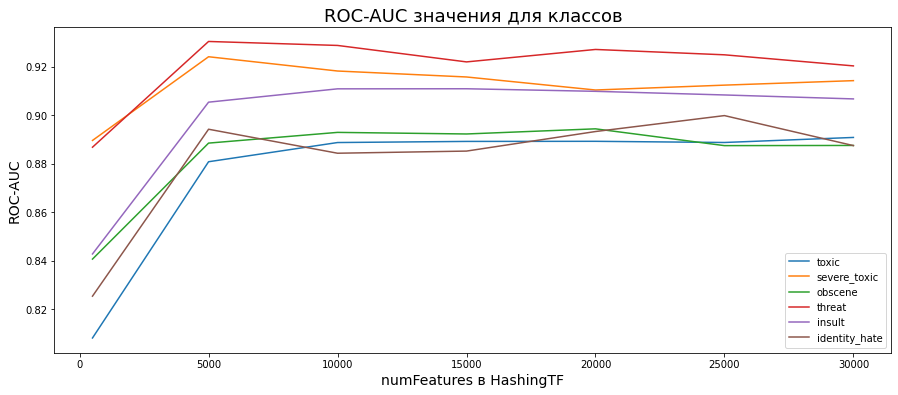

In [12]:
# График ROC AUC в зависимости от количества фич
plt.rcParams["figure.figsize"] = (15,6)


for i_cls in class_target:
  plt.plot(number_of_features, res_clsf_metrics_df[res_clsf_metrics_df.loc[:, 'class'] == i_cls].roc_auc, label=i_cls)

plt.title('ROC-AUC значения для классов',fontsize=18)
plt.xlabel("numFeatures в HashingTF",fontsize=14)
plt.ylabel("ROC-AUC",fontsize=14)
plt.legend()

1. Видим что есть небольшой разброс по качетсву классификации контента, но в целом результаты получились довольно хорошими. Иными словами, качество классификации близкое для всех классов.

2. Для всех моделей качество сильно увеличилось при увеличении количества фич (numFeatures) до 5000, т.е растет довольно быстро. Причем для некоторых таргетов рост чуть больше, чем к примеру у threat и severe_toxic. После 5000 фич качество примерно остается постоянным, но все равно зависит от класса, так как может немного проседать у избранных классов. Но можно сказать что после 5000 фич мы уже не сильно прибавляем в качестве, для нашего набора фич, и мы на насыщении по качетсву.

P.S: Наблюдение, вначале поставил учиться логистическую регрессию без выставления количества итераций (maxIter) и без regParam, и результаты были удручающие. Т.е. с увеличением числа фич они наоборот падали, в сравнении с тем что тут. Поэтому стоит на зависимость от numFeatures смотреть при других хорошо подобранных оптимизационных параметрах.

# Word2Vec

In [13]:
word2Vec = Word2Vec(vectorSize=100, seed=33, inputCol="filtered_tokens", outputCol="features")
word2Vec_fit = word2Vec.fit(res_train_df)

w2v_df_train = word2Vec_fit.transform(res_train_df).cache()
w2v_df_test = word2Vec_fit.transform(res_test_df).cache()

In [16]:
res_w2v_clsf_metrics = []

for i_class in class_target:
    
    # Инициализирую логистическую регрессию и делаю предикт класса
    data_to_train_w2v = w2v_df_train.select(["id", "features", col(i_class).cast("int")])
    
    log_reg = LogisticRegression(
                                featuresCol="features",
                                labelCol=i_class,
                                maxIter=200,
                                regParam=0.05
                                )
    log_reg_fit = log_reg.fit(data_to_train_w2v)
    pred_ = log_reg_fit.transform(w2v_df_test)

    # Извлекаю метрики
    result = test_data.select(["id", i_class]).join(pred_.select("id", "probability"), on="id")
    result = result.select(col(i_class).cast("int").alias("label"), col("probability"))
    clsf_res = BinaryClassificationEvaluator(metricName="areaUnderROC", rawPredictionCol="probability")

    res_w2v_clsf_metrics.append({"class": i_class, "roc_auc": clsf_res.evaluate(result)})


res_w2v_clsf_metrics_df = pd.DataFrame(res_w2v_clsf_metrics)

In [17]:
res_w2v_clsf_metrics_df

,class,roc_auc
0,toxic,0.954271
1,severe_toxic,0.983114
2,obscene,0.972225
3,threat,0.953002
4,insult,0.962210
5,identity_hate,0.962960


# Word2Vec Ответ на вопрос

По результатам классификации методом word2vec мы видим, что качество моделей превосходит качество моделей при применении метода TF-IDF. Например, по классу threat word2vec выдал самое плохое качество классификации(0.955), но даже этот результат лучше в сравнении с TF-IDF для того же threat, хотя при TF-IDF в среднем для threat качество самое высокое(в пределах 0.92-0.93) среди всех классов. Получился хороший результат при прочих равных.

In [18]:
# И по правилу хорошего тона, уберем из памяти

w2v_df_train.unpersist()
w2v_df_test.unpersist()

res_train_df.unpersist()
res_test_df.unpersist()

DataFrame[id: string, comment_text: string, toxic: string, severe_toxic: string, obscene: string, threat: string, insult: string, identity_hate: string, tokens: array<string>, filtered_tokens: array<string>]